In [1]:
import os, random
from unicodedata import name
import pandas as pd
import numpy as np
import scipy.stats as stats
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from model import APANET, APAData
from train_script import build_dataloaders
import pickle
# from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import xml.etree.ElementTree as ET
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import MinMaxScaler

In [2]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [3]:
MODELS_ROOT = '/home/aiden/codes/APA-Net_2024_05_08_v2_28_May/model_outs/significant'
DATA_ROOT = '/home/aiden/data/APA/22May/significant/'

In [4]:
# initialize the model
config = {
        "batch_size":64,
        "epochs": 32,
        "project_name": 'test_performace',
        "device": 'cuda',
        "opt": "Adam",
        "loss": "mse",
        "lr": 2.5e-05,
        "adam_weight_decay": 0.09, # 0.06 before
        "conv1kc": 128, #128, 64
        "conv1ks": 12,
        "conv1st": 1,
        "pool1ks": 16,
        "pool1st": 16,
        "cnvpdrop1": 0,
        "Matt_heads": 8,
        "Matt_drop": 0.2,
        "fc1_dims": [
            8192, # 8192, 5120
            4048,
            1024,
            512,
            256,
        ],  # first dimension will be calculated dynamically
        "fc1_dropouts": [0.25, 0.25, 0.25, 0, 0],
        "fc2_dims": [128, 32, 16, 1],  # first dimension will be calculated dynamically
        "fc2_dropouts": [0.2, 0.2, 0, 0],
        'psa_query_dim': 128, # make sure this is correct
        'psa_num_layers': 1,
        'psa_nhead': 1,
        'psa_dim_feedforward':1024,
        'psa_dropout': 0 
    }

def get_model(model_path='model.pth'):
    model = APANET(config)
    model.load_state_dict(torch.load(model_path, map_location='cuda'))
    model.eval()
    return model
model = get_model(f'{MODELS_ROOT}/model_out_fold4.pt').to('cuda')
model

/home/aiden/anaconda3/envs/for_DL_2024/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


APANET(
  (conv_block_1): ConvBlock(
    (op): Sequential(
      (0): Conv1d(4, 128, kernel_size=(12,), stride=(1,), padding=(6,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): MaxPool1d(kernel_size=16, stride=16, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout(p=0, inplace=False)
    )
  )
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (fc1): FCBlock(
    (op): Sequential(
      (0): Linear(in_features=32000, out_features=8192, bias=True)
      (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.25, inplace=False)
      (4): Linear(in_features=8192, out_features=4048, bias=True)
      (5): BatchNorm1d(4048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.25, inplace=False)
  

In [5]:
ct_filter_importance = {}
test_data = np.load(f'{DATA_ROOT}test_fold_4.npy', allow_pickle=True)
# group by celltype (column 1: data[:, 1]) and build celltype specific dataloaders
test_data = pd.DataFrame(test_data)
# for each uniq cell type 1 dataloader
for ct in test_data[1].unique():
    print(ct)
    ct_data = test_data[test_data[1] == ct]
    ct_data_loader, _ = build_dataloaders('cuda',
                                            ct_data.values,
                                            ct_data.values,
                                            config["batch_size"])
    filter_importance = np.zeros((len(ct_data_loader)*64, 128, 250))
    with torch.no_grad():
        for batch_idx, batch in enumerate(ct_data_loader):
            seq_X, Y, celltype, celltype_name, _ = batch
            fmap = model.conv_block_1(seq_X)
            # fmap = fmap.permute(0, 2, 1)  # reshape for attention block so dim is first
            # x, _ = self.attention(x, x, x)
            # fmap = model.process_self_attn(fmap)
            # fmap = fmap.permute(0, 2, 1)  # reshape back to original
            fmap = fmap.cpu().detach().numpy()
            filter_importance[batch_idx:batch_idx+64] = fmap
    ct_filter_importance[ct] = filter_importance

Astro
Exc_deep
Exc_int
Exc_upper
Inh
Microglia
OPC
Oligo


(128, 250)


/home/aiden/anaconda3/envs/for_DL_2024/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/aiden/anaconda3/envs/for_DL_2024/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


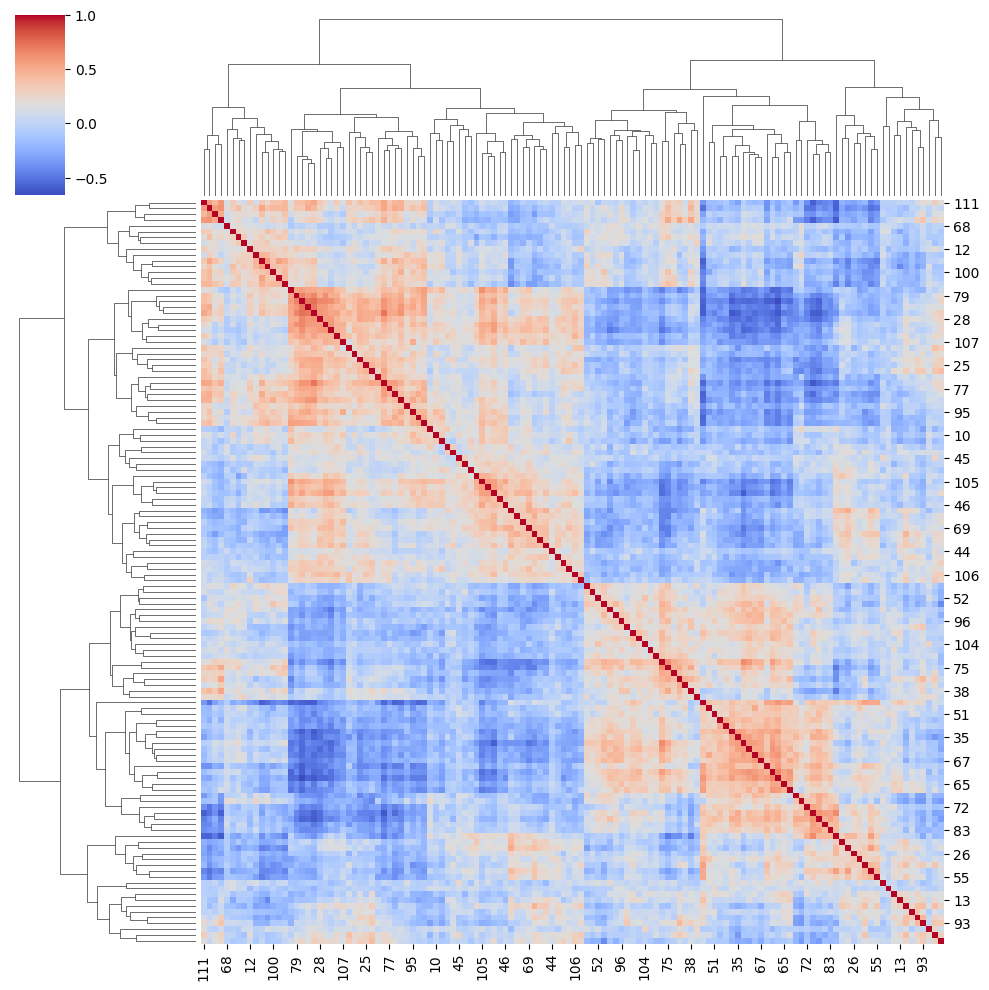

In [53]:
filter_importance_t = ct_filter_importance['OPC']
# filter_importance_t[filter_importance_t < 0] = 0
filter_importance_t = np.mean(filter_importance_t, axis=0)  # shape: (128, 250)
print(filter_importance_t.shape)
# Calculate the correlation between filters at each position
correlation = np.corrcoef(filter_importance_t)  
sns.clustermap(correlation, cmap='coolwarm')

In [81]:
tree = ET.parse('tomtom.xml')
root = tree.getroot()

rbp_group_dict = {}

# Find all motif elements within the targets section and extract the id attributes
for motif in root.findall('.//targets/motif'):
    motif_id = motif.get('id')
    motif_name = motif.get('alt')  # Assuming 'alt' is the attribute for alternative names, adjust if needed
    if motif_name is None:
        motif_name = motif_id  # Use id as the name if 'alt' is not available
    rbp_group_dict[motif_id] = motif_name

df = pd.read_csv('/home/aiden/codes/APA-Net_2024_05_08_v2_28_May/apamodel/tomtom_fromhtml.tsv', sep='\t')
df['RBP'] = df['Target_ID'].map(rbp_group_dict)
# remove nan values in p-value
df = df.dropna(subset=['p-value'])
print(df.shape)

# p-value adjust the p-value
_, adjusted_pvals, _, _ = multipletests(df['p-value'].values, alpha=0.05, method='fdr_bh')
df['adjusted_pvalue'] = adjusted_pvals

df = df[df['adjusted_pvalue'] < 0.05]
print(df.shape)
df.head()

(1807, 11)
(1807, 11)


,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation,RBP
0,filter_0,RNCMPT00134,0.0,0.000499,0.121857,0.085627,7.0,GGGGGGCUCGGG,GGAGGGG,+,B52
1,filter_0,RNCMPT00160,0.0,0.000809,0.197362,0.085627,7.0,GGGGGGCUCGGG,GGGAGGG,+,HNRNPH2
2,filter_0,RNCMPT00163,0.0,0.001119,0.273101,0.085627,7.0,GGGGGGCUCGGG,GGAGGAG,+,SRSF1
3,filter_0,RNCMPT00109,0.0,0.001987,0.484795,0.093923,7.0,GGGGGGCUCGGG,GGAGGAA,+,SRSF1
4,filter_0,RNCMPT00052,-5.0,0.002865,0.698975,0.093923,7.0,GGGGGGCUCGGG,GCGCGGG,+,RBM4


In [65]:
idmap = pd.read_csv('idmap.csv')
# remove NaN
# idmap = idmap.dropna()
idmap = idmap.dropna(subset='symbol')
idmap

,query,entrezgene,name,symbol,alias,taxid,HGNC
0,A1CF,29974.0,APOBEC1 complementation factor,A1CF,"ACF, ACF64, ACF65, APOBEC1CF, ASP",9606.0,HGNC:24086
1,ANKHD1,54882.0,ankyrin repeat and KH domain containing 1,ANKHD1,"MASK, MASK1, PP2500, VBARP",9606.0,HGNC:24714
2,RBP1,5926.0,AT-rich interaction domain 4A,ARID4A,"RBBP-1, RBBP1, RBP-1, RBP1",9606.0,HGNC:9885
3,ETR-1,11189.0,CUGBP Elav-like family member 3,CELF3,"BRUNOL1, CAGH4, ERDA4, ETR-1, TNRC4",9606.0,HGNC:11967
4,BRUNOL4,56853.0,CUGBP Elav-like family member 4,CELF4,"BRUNOL4, CELF-4",9606.0,HGNC:14015
...,...,...,...,...,...,...,...
92,YBX2,51087.0,Y-box binding protein 2,YBX2,"CONTRIN, CSDA3, DBPC, MSY2",9606.0,HGNC:17948
93,ZC3H10,84872.0,zinc finger CCCH-type containing 10,ZC3H10,ZC3HDC10,9606.0,HGNC:25893
94,ZC3H14,79882.0,zinc finger CCCH-type containing 14,ZC3H14,"MRT56, MSUT-2, NY-REN-37, SUT2, UKp68",9606.0,HGNC:20509
95,ZCRB1,85437.0,zinc finger CCHC-type and RNA binding motif co...,ZCRB1,"MADP-1, MADP1, RBM36, SNRNP31, ZCCHC19",9606.0,HGNC:29620


In [66]:
print(len(idmap['symbol']))
print(len(idmap['symbol'].unique()))

97
92


In [87]:
df[df['Target_ID'] == 'RNCMPT00274']

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation,RBP
41,filter_3,RNCMPT00274,-2.0,0.005611,1.369100,0.123520,7.0,UUUUUUAUUUUC,UUUUUUU,+,HuR
58,filter_4,RNCMPT00274,-4.0,0.003049,0.743866,0.112207,7.0,AGACUUUUUCUG,UUUUUUU,+,HuR
106,filter_7,RNCMPT00274,-2.0,0.014252,3.477390,0.357350,7.0,UUUUAUUUUAAU,UUUUUUU,+,HuR
130,filter_8,RNCMPT00274,-3.0,0.021182,5.168450,0.363371,7.0,CUGUUCUUGUGC,UUUUUUU,+,HuR
298,filter_24,RNCMPT00274,-1.0,0.000539,0.131489,0.020109,7.0,UUUUUUUUCUUC,UUUUUUU,+,HuR
417,filter_32,RNCMPT00274,1.0,0.011456,2.795370,0.243549,6.0,UUUUAUAUAUUU,UUUUUUU,+,HuR
445,filter_34,RNCMPT00274,0.0,0.000014,0.003518,0.001068,7.0,UUUUUUUUUUUU,UUUUUUU,+,HuR
489,filter_35,RNCMPT00274,-4.0,0.018076,4.410600,0.238005,7.0,AUAUUUUAUUUU,UUUUUUU,+,HuR
506,filter_36,RNCMPT00274,-1.0,0.004952,1.208180,0.147895,7.0,AUUUUUCUAAGG,UUUUUUU,+,HuR
623,filter_48,RNCMPT00274,0.0,0.000867,0.211659,0.026934,7.0,UUUCUUUCCUUU,UUUUUUU,+,HuR


In [88]:
# make sure the df['RBP'] is all upper case
df['RBP'] = df['RBP'].str.upper()

In [89]:
df = df[df['RBP'].isin(idmap['query'])]
# map 'symbol' column to df['RBP']
# idmap = idmap.dropna(subset='symbol')
query_target = dict(zip(idmap['query'], idmap['symbol']))
df['RBP'] = df['RBP'].map(query_target)
df

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation,RBP
0,filter_0,RNCMPT00134,0.0,0.000499,0.121857,0.085627,7.0,GGGGGGCUCGGG,GGAGGGG,+,SRSF6
1,filter_0,RNCMPT00160,0.0,0.000809,0.197362,0.085627,7.0,GGGGGGCUCGGG,GGGAGGG,+,HNRNPH2
2,filter_0,RNCMPT00163,0.0,0.001119,0.273101,0.085627,7.0,GGGGGGCUCGGG,GGAGGAG,+,SRSF1
3,filter_0,RNCMPT00109,0.0,0.001987,0.484795,0.093923,7.0,GGGGGGCUCGGG,GGAGGAA,+,SRSF1
4,filter_0,RNCMPT00052,-5.0,0.002865,0.698975,0.093923,7.0,GGGGGGCUCGGG,GCGCGGG,+,RBM4
...,...,...,...,...,...,...,...,...,...,...,...
1794,filter_126,RNCMPT00150,-6.0,0.024775,6.045160,0.997680,6.0,AGGGCUUGGGAA,UGGGGAU,+,ESRP2
1795,filter_126,RNCMPT00285,-1.0,0.037152,9.065010,0.997680,8.0,AGGGCUUGGGAA,GAGUGUGG,+,RBM24
1796,filter_126,RNCMPT00272,-5.0,0.039517,9.642080,0.997680,7.0,AGGGCUUGGGAA,GUAGGUA,+,SRP54
1797,filter_127,RNCMPT00151,-3.0,0.005471,1.334920,0.696685,7.0,GCCAACUCAGGC,AACUAAG,+,RBM42


In [90]:
# filter to RBP dictionary
rbp_filter_dict = {}
for row in df.itertuples():
    rbp = row.RBP
    filter = row.Query_ID
    if filter not in rbp_filter_dict:
        rbp_filter_dict[filter] = []
    rbp_filter_dict[filter].append(rbp)
rbp_filter_dict

{'filter_0': ['SRSF6',
  'HNRNPH2',
  'SRSF1',
  'SRSF1',
  'RBM4',
  'SRSF1',
  'RBM4',
  'SRSF1',
  'SRSF1',
  'LIN28A',
  'PPRC1',
  'ZC3H10',
  'RBM8A',
  'RBM4',
  'SRSF1',
  'FUS'],
 'filter_1': ['NR5A1',
  'SNRNP70',
  'SRSF9',
  'FXR1',
  'KHDRBS2',
  'SRSF10',
  'SRSF10',
  'KHDRBS3'],
 'filter_3': ['TIA1',
  'ELAVL1',
  'U2AF2',
  'ELAVL1',
  'RALY',
  'PTBP1',
  'TIA1',
  'PTBP1',
  'HNRNPCL1',
  'HNRNPC',
  'CPEB4'],
 'filter_4': ['PTBP1',
  'ELAVL1',
  'RALY',
  'U2AF2',
  'TIA1',
  'TIA1',
  'PTBP1',
  'CPEB4',
  'ELAVL1',
  'PCBP3',
  'CPEB2',
  'HNRNPCL1',
  'HNRNPC',
  'CELF3',
  'ELAVL1',
  'ANKHD1',
  'ZC3H14'],
 'filter_5': ['CPEB2', 'CPEB4', 'PTBP1', 'ELAVL1'],
 'filter_6': ['SRSF10', 'SRSF10', 'SRSF1', 'PABPN1'],
 'filter_7': ['ELAVL1',
  'ELAVL1',
  'RBM41',
  'ELAVL1',
  'MYOD1',
  'ZC3H14',
  'ELAVL1'],
 'filter_8': ['CPEB4', 'TIA1', 'ELAVL1', 'CPEB2', 'PTBP1', 'MATR3', 'ZNF638'],
 'filter_9': ['KHDRBS1', 'ARID4A', 'SF3B4'],
 'filter_10': ['RBM24', 'RBM42'],
 '

In [91]:
filter_importance_t_df = pd.DataFrame(filter_importance_t)
new_index_names = ['filter_{}'.format(i) for i in range(128)]
filter_importance_t_df.index = new_index_names
filter_importance_t_df

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
filter_0,0.117966,0.110230,0.120386,0.104560,0.112026,0.104063,0.105850,0.107175,0.115578,0.114248,...,0.104640,0.106618,0.107871,0.112967,0.101377,0.102075,0.107059,0.109245,0.113876,0.101696
filter_1,0.111562,0.118561,0.110812,0.114536,0.108875,0.111125,0.108522,0.113814,0.107013,0.113053,...,0.113526,0.115003,0.120216,0.114703,0.115090,0.103145,0.109316,0.114801,0.120163,0.106191
filter_2,0.107978,0.114257,0.114510,0.106181,0.120225,0.112212,0.112902,0.114427,0.115442,0.118177,...,0.105752,0.112392,0.113464,0.113068,0.103210,0.113561,0.114179,0.109260,0.111840,0.108551
filter_3,0.098285,0.110832,0.115011,0.106865,0.106661,0.105454,0.114311,0.108528,0.107675,0.107693,...,0.103739,0.104199,0.112191,0.110565,0.106931,0.110481,0.105793,0.105848,0.105404,0.102880
filter_4,0.108862,0.112527,0.114579,0.113306,0.119177,0.108324,0.110135,0.108373,0.112546,0.112613,...,0.107954,0.111664,0.109901,0.109757,0.117426,0.111712,0.114423,0.113280,0.111849,0.112379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
filter_123,0.116124,0.105680,0.106802,0.111825,0.110100,0.108205,0.109530,0.099497,0.102126,0.112707,...,0.101111,0.110013,0.103866,0.116215,0.107609,0.108396,0.111203,0.111094,0.101591,0.100828
filter_124,0.110931,0.109003,0.114736,0.120437,0.113566,0.114990,0.113015,0.107604,0.108213,0.109963,...,0.116663,0.113596,0.117724,0.110503,0.113975,0.120227,0.111630,0.104478,0.113208,0.104459
filter_125,0.117808,0.113914,0.115112,0.114466,0.119107,0.106689,0.112528,0.105822,0.113615,0.108414,...,0.113852,0.113902,0.108616,0.112479,0.113557,0.109252,0.111488,0.110381,0.111043,0.108441
filter_126,0.114652,0.113868,0.115172,0.109199,0.112453,0.115749,0.110813,0.100843,0.105989,0.112551,...,0.110022,0.102811,0.113418,0.118479,0.114211,0.104383,0.111236,0.112323,0.110704,0.122341


In [92]:
new_data = []
# Iterate over each filter
for filter_name, rbps in rbp_filter_dict.items():
    # Get the importance scores for the current filter
    imp_scores = filter_importance_t_df.loc[filter_name]
    # For each RBP that binds to this filter, duplicate the importance scores
    for rbp in rbps:
        row_data = imp_scores.to_dict()
        row_data['RBP'] = rbp
        new_data.append(row_data)

new_df = pd.DataFrame(new_data)

# Reorder columns to have 'RBP' as the first column
cols = ['RBP'] + [col for col in new_df.columns if col != 'RBP']
new_df = new_df[cols]
# Now new_df contains the importance scores duplicated for each RBP that binds to each filter
new_df

,RBP,0,1,2,3,4,5,6,7,8,...,240,241,242,243,244,245,246,247,248,249
0,SRSF6,0.117966,0.110230,0.120386,0.104560,0.112026,0.104063,0.105850,0.107175,0.115578,...,0.104640,0.106618,0.107871,0.112967,0.101377,0.102075,0.107059,0.109245,0.113876,0.101696
1,HNRNPH2,0.117966,0.110230,0.120386,0.104560,0.112026,0.104063,0.105850,0.107175,0.115578,...,0.104640,0.106618,0.107871,0.112967,0.101377,0.102075,0.107059,0.109245,0.113876,0.101696
2,SRSF1,0.117966,0.110230,0.120386,0.104560,0.112026,0.104063,0.105850,0.107175,0.115578,...,0.104640,0.106618,0.107871,0.112967,0.101377,0.102075,0.107059,0.109245,0.113876,0.101696
3,SRSF1,0.117966,0.110230,0.120386,0.104560,0.112026,0.104063,0.105850,0.107175,0.115578,...,0.104640,0.106618,0.107871,0.112967,0.101377,0.102075,0.107059,0.109245,0.113876,0.101696
4,RBM4,0.117966,0.110230,0.120386,0.104560,0.112026,0.104063,0.105850,0.107175,0.115578,...,0.104640,0.106618,0.107871,0.112967,0.101377,0.102075,0.107059,0.109245,0.113876,0.101696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,ESRP2,0.114652,0.113868,0.115172,0.109199,0.112453,0.115749,0.110813,0.100843,0.105989,...,0.110022,0.102811,0.113418,0.118479,0.114211,0.104383,0.111236,0.112323,0.110704,0.122341
1046,RBM24,0.114652,0.113868,0.115172,0.109199,0.112453,0.115749,0.110813,0.100843,0.105989,...,0.110022,0.102811,0.113418,0.118479,0.114211,0.104383,0.111236,0.112323,0.110704,0.122341
1047,SRP54,0.114652,0.113868,0.115172,0.109199,0.112453,0.115749,0.110813,0.100843,0.105989,...,0.110022,0.102811,0.113418,0.118479,0.114211,0.104383,0.111236,0.112323,0.110704,0.122341
1048,RBM42,0.099865,0.111595,0.109300,0.113793,0.112377,0.105920,0.107303,0.105424,0.104090,...,0.106949,0.103142,0.107102,0.110682,0.109906,0.108320,0.111604,0.108463,0.103405,0.114208


In [93]:
# Group by 'RBP' and calculate the mean for each group
averaged_df = new_df.groupby('RBP').mean().reset_index()
scaler = MinMaxScaler(feature_range=(0,1))
scaled_values = scaler.fit_transform(averaged_df.iloc[:, 1:])
averaged_df.iloc[:, 1:] = scaled_values
averaged_df

,RBP,0,1,2,3,4,5,6,7,8,...,240,241,242,243,244,245,246,247,248,249
0,A1CF,0.509659,0.549705,0.499736,0.516849,0.363418,0.634709,0.555860,0.632036,0.327259,...,0.377667,0.547345,0.829567,0.508576,0.331204,0.409426,0.755132,0.251253,0.432533,0.305191
1,ANKHD1,0.540341,0.401781,0.757470,0.696367,0.868407,0.733189,0.579482,0.433463,0.587292,...,0.027670,0.739526,0.418452,0.501107,0.938904,0.648149,0.577567,0.443341,0.542230,0.556284
2,ARID4A,0.599164,0.397885,0.839606,0.867685,0.818982,0.833377,0.681647,0.602787,0.664648,...,0.601346,0.761659,0.668029,0.543908,0.723215,0.713842,0.579572,0.497886,0.699279,0.487051
3,CELF3,0.437821,0.514101,0.666937,0.598419,0.640486,0.535128,0.572609,0.405800,0.487069,...,0.112169,0.617061,0.599251,0.557314,0.573889,0.585969,0.813840,0.271788,0.293217,0.455227
4,CELF4,0.508228,0.651735,0.811235,0.593489,0.792232,0.742583,0.567552,0.604036,0.548095,...,0.455959,0.769325,0.975072,0.651447,0.654567,0.681284,0.936530,0.407857,0.421919,0.501616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,YBX2,0.367578,0.263877,0.482079,0.604316,0.762892,0.647552,0.480747,0.358782,0.466128,...,0.324040,0.426097,0.320383,0.183687,0.568342,0.588101,0.331723,0.405771,0.421319,0.270783
88,ZC3H10,0.496775,0.387475,0.615777,0.633151,0.752402,0.660890,0.546746,0.363744,0.532681,...,0.241514,0.609099,0.466065,0.560153,0.480127,0.464994,0.550231,0.342032,0.367893,0.447700
89,ZC3H14,0.466099,0.434347,0.480501,0.469457,0.594864,0.460916,0.372539,0.347081,0.376172,...,0.187542,0.638574,0.525439,0.529042,0.463422,0.544062,0.778865,0.231617,0.223652,0.366746
90,ZCRB1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.572622,...,0.256348,0.000000,0.642951,0.197787,0.000000,0.000000,0.000000,0.248393,0.223991,0.068837


In [94]:
averaged_df = averaged_df.set_index('RBP')
corr = averaged_df.T.corr()
corr

RBP,A1CF,ANKHD1,ARID4A,CELF3,CELF4,CELF5,CELF6,CNOT4,CPEB2,CPEB4,...,TARDBP,TIA1,TUT1,U2AF2,YBX1,YBX2,ZC3H10,ZC3H14,ZCRB1,ZNF638
RBP,,,,,,,,,,,,,,,,,,,,,
A1CF,1.000000,-0.020586,-0.228414,0.653531,0.618546,0.371964,0.561054,-0.042230,0.465078,0.446162,...,0.166906,0.522838,0.284844,0.472539,-0.109011,-0.077010,-0.189141,0.592523,0.193307,0.384035
ANKHD1,-0.020586,1.000000,0.541460,0.344253,0.121585,0.167200,0.084066,0.495147,0.272177,0.261026,...,0.087576,0.247390,-0.110671,0.231691,0.484905,0.424844,0.486129,0.218606,-0.234346,0.120561
ARID4A,-0.228414,0.541460,1.000000,-0.119730,-0.095709,0.007732,-0.118672,0.653801,-0.018107,-0.031078,...,0.191614,-0.069678,-0.125787,-0.085217,0.645325,0.612389,0.540945,-0.122484,-0.319821,-0.153233
CELF3,0.653531,0.344253,-0.119730,1.000000,0.725071,0.553448,0.626899,0.057476,0.754254,0.754776,...,0.204434,0.802665,0.194532,0.783373,0.088341,0.038399,0.012036,0.837790,0.052386,0.648227
CELF4,0.618546,0.121585,-0.095709,0.725071,1.000000,0.872787,0.706336,-0.035224,0.660813,0.663725,...,0.424579,0.710157,0.201440,0.638239,-0.015444,-0.019072,-0.102356,0.768713,0.127251,0.548761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YBX2,-0.077010,0.424844,0.612389,0.038399,-0.019072,0.055428,-0.186440,0.874696,0.170117,0.144014,...,0.087026,0.073390,0.140689,0.095579,0.802090,1.000000,0.224056,0.028539,-0.311080,0.179582
ZC3H10,-0.189141,0.486129,0.540945,0.012036,-0.102356,0.022891,0.135888,0.375143,0.098607,0.082644,...,-0.142107,0.081522,-0.411054,0.075414,0.483047,0.224056,1.000000,0.038539,-0.296389,-0.239409
ZC3H14,0.592523,0.218606,-0.122484,0.837790,0.768713,0.696763,0.654216,0.090940,0.928026,0.923054,...,0.214373,0.960684,0.137017,0.938431,0.156473,0.028539,0.038539,1.000000,0.020229,0.725023


In [96]:
for ct in ct_filter_importance:
    print(ct)
    filter_importance_t = np.mean(ct_filter_importance[ct], axis=0)  
    filter_importance_t_df = pd.DataFrame(filter_importance_t)
    new_index_names = ['filter_{}'.format(i) for i in range(128)]
    filter_importance_t_df.index = new_index_names
    new_data = []
    for filter_name, rbps in rbp_filter_dict.items():
        imp_scores = filter_importance_t_df.loc[filter_name]
        for rbp in rbps:
            row_data = imp_scores.to_dict()
            row_data['RBP'] = rbp
            new_data.append(row_data)
    new_df = pd.DataFrame(new_data)
    cols = ['RBP'] + [col for col in new_df.columns if col != 'RBP']
    new_df = new_df[cols]
    averaged_df = new_df.groupby('RBP').mean().reset_index()
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_values = scaler.fit_transform(averaged_df.iloc[:, 1:])
    averaged_df.iloc[:, 1:] = scaled_values
    averaged_df = averaged_df.set_index('RBP')
    corr = averaged_df.T.corr()
    corr.to_csv(f'filter_interactions/{ct}_corr.csv')

Astro
Exc_deep
Exc_int
Exc_upper
Inh
Microglia
OPC
Oligo


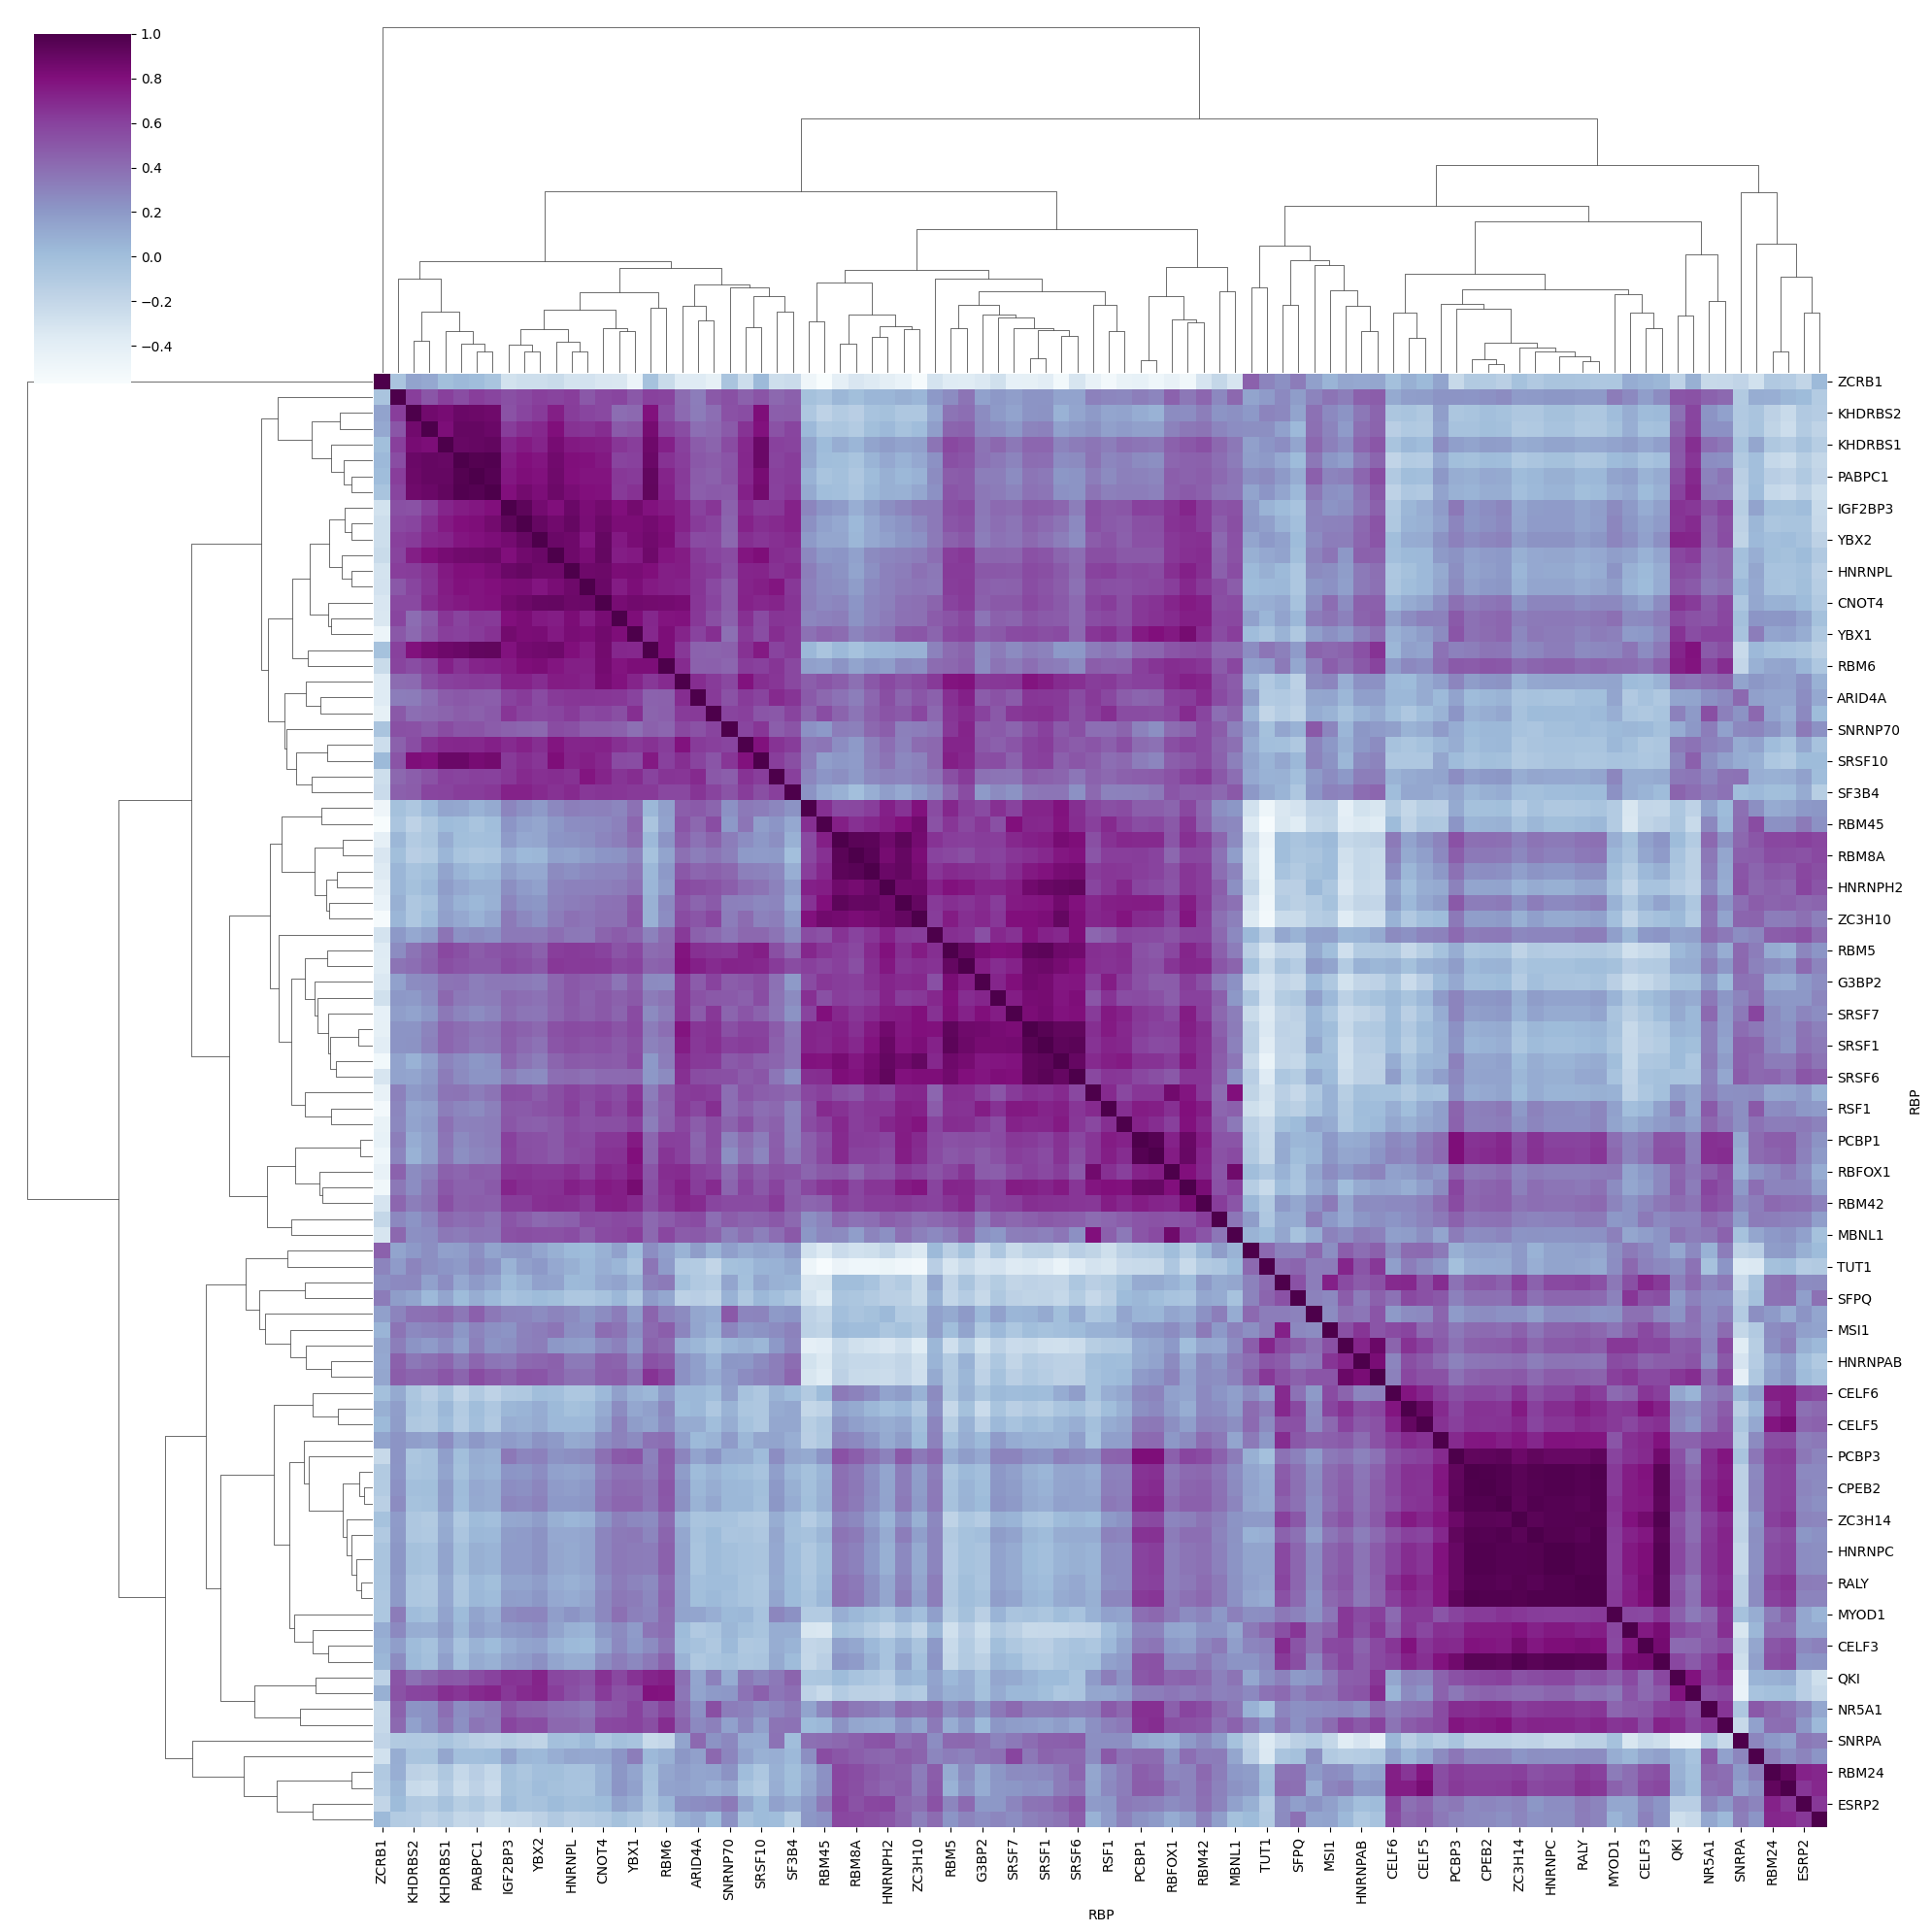

In [97]:
cluster_map = sns.clustermap(corr, cmap='BuPu', figsize=(20,20))

In [98]:
corr

RBP,A1CF,ANKHD1,ARID4A,CELF3,CELF4,CELF5,CELF6,CNOT4,CPEB2,CPEB4,...,TARDBP,TIA1,TUT1,U2AF2,YBX1,YBX2,ZC3H10,ZC3H14,ZCRB1,ZNF638
RBP,,,,,,,,,,,,,,,,,,,,,
A1CF,1.000000,0.114957,-0.096741,0.687318,0.702131,0.522359,0.695959,0.118516,0.498863,0.480942,...,0.302628,0.529824,0.413322,0.453872,0.064258,0.154227,-0.233018,0.601763,0.241677,0.539084
ANKHD1,0.114957,1.000000,0.558670,0.341188,0.254255,0.300345,0.215671,0.542745,0.377913,0.359435,...,0.184387,0.339277,-0.075815,0.296760,0.555246,0.420751,0.392561,0.317812,-0.202711,0.226589
ARID4A,-0.096741,0.558670,1.000000,-0.033731,0.043354,0.110010,0.038532,0.647571,0.043905,0.015267,...,0.179201,-0.004541,-0.109315,-0.032446,0.595327,0.558590,0.504324,-0.052614,-0.363158,-0.097227
CELF3,0.687318,0.341188,-0.033731,1.000000,0.789393,0.649014,0.648041,0.152863,0.778659,0.789371,...,0.291056,0.810927,0.307211,0.768739,0.201083,0.159077,-0.049173,0.858640,0.069926,0.761122
CELF4,0.702131,0.254255,0.043354,0.789393,1.000000,0.912595,0.776060,0.107754,0.660589,0.663524,...,0.407536,0.700122,0.325768,0.606147,0.125768,0.099804,-0.092815,0.760182,0.083022,0.649286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YBX2,0.154227,0.420751,0.558590,0.159077,0.099804,0.110529,0.003298,0.905168,0.285380,0.254219,...,0.137961,0.210405,0.200872,0.228035,0.831078,1.000000,0.238299,0.179739,-0.260825,0.244860
ZC3H10,-0.233018,0.392561,0.504324,-0.049173,-0.092815,-0.011165,0.071811,0.387697,0.180799,0.173314,...,-0.344798,0.156674,-0.524638,0.167316,0.506186,0.238299,1.000000,0.084865,-0.546652,-0.201452
ZC3H14,0.601763,0.317812,-0.052614,0.858640,0.760182,0.710749,0.662743,0.222680,0.950313,0.949913,...,0.193627,0.972229,0.196217,0.946927,0.279681,0.179739,0.084865,1.000000,-0.027424,0.788050
